In [2]:
# + tags=[]
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
import numpy as np
%matplotlib inline

## 1. AIS-Datenvorverarbeitung: Filterung, Δt-Berechnung & Cargo-Klassifikation

In [3]:
# ───────────────────────────────────────────────────────────────────────
# 1) CSV einlesen und erste Filterungen
# ───────────────────────────────────────────────────────────────────────
import pandas as pd

df = pd.read_csv(
    "data/processed/ais/ais_data_fehmarn_radius.csv",
    dtype={"MMSI": str},
    low_memory=False
)
print(f"📥  Ursprüngliche AIS-Meldungen geladen: {len(df):,}")

# Filter: nur Class A / B, „Under way using engine“, GPS-Positionen
initial_count = len(df)
df = df[df["Type of mobile"].isin(["Class A", "Class B"])]
print(f"🔹 Nach Mobile-Typ-Filter (Class A/B): {len(df):,} (entfernt {initial_count-len(df):,})")
before_nav = len(df)
df = df[df["Navigational status"] == "Under way using engine"]
print(f"🔹 Nach Navigational-Status-Filter: {len(df):,} (entfernt {before_nav-len(df):,})")
before_gps = len(df)
df = df[df["Type of position fixing device"] == "GPS"]
print(f"🔹 Nach Position-Fixing-Filter: {len(df):,} (entfernt {before_gps-len(df):,})\n")

# ───────────────────────────────────────────────────────────────────────
# 2) Timestamps sauber parsen & ungültige Zeilen verwerfen
# ───────────────────────────────────────────────────────────────────────
df["# Timestamp"] = pd.to_datetime(
    df["# Timestamp"],
    dayfirst=True,   # Format: Tag/Monat/Jahr
    errors="coerce"  # Ungültige → NaT
)
n0 = len(df)
df = df.dropna(subset=["# Timestamp"])
n1 = len(df)
print(f"🕒 Timestamp geparsed: {n0-n1:,} fehlerhafte Zeilen verworfen → {n1:,} verbleibend\n")

# ───────────────────────────────────────────────────────────────────────
# 3) Δt-Spalte berechnen (Sekunden)
# ───────────────────────────────────────────────────────────────────────
df = df.sort_values(["MMSI", "# Timestamp"]).reset_index(drop=True)
df["delta_t"] = (
    df.groupby("MMSI")["# Timestamp"]
      .diff()
      .dt.total_seconds()
      .fillna(0)
)
print(f"⏱ Δt (Zeitdifferenz) hinzugefügt für {len(df):,} Meldungen\n")

# ───────────────────────────────────────────────────────────────────────
# 4) Zielvariable: Cargo vs. Other
# ───────────────────────────────────────────────────────────────────────
df["is_cargo"] = (df["Ship type"] == "Cargo").astype(int)

counts = df["is_cargo"].value_counts().rename({1: "Cargo", 0: "Other"})
print("🚢 Klassenverteilung nach Filterung:")
for cls, cnt in counts.items():
    pct = cnt / len(df) * 100
    print(f"   • {cls:<5}: {cnt:,} ({pct:.1f} %)")
print()

# ───────────────────────────────────────────────────────────────────────
# 5) Stichprobe wichtiger Merkmale
# ───────────────────────────────────────────────────────────────────────
print("🔍 Stichprobe ausgewählter Features:")
display(
    df[["SOG", "COG", "Draught", "Width", "Length", "delta_t", "ROT", "is_cargo"]]
      .sample(10, random_state=42)
      .reset_index(drop=True)
)

📥  Ursprüngliche AIS-Meldungen geladen: 9,843,863
🔹 Nach Mobile-Typ-Filter (Class A/B): 9,742,712 (entfernt 101,151)
🔹 Nach Navigational-Status-Filter: 7,577,311 (entfernt 2,165,401)
🔹 Nach Position-Fixing-Filter: 6,395,761 (entfernt 1,181,550)

🕒 Timestamp geparsed: 0 fehlerhafte Zeilen verworfen → 6,395,761 verbleibend

⏱ Δt (Zeitdifferenz) hinzugefügt für 6,395,761 Meldungen

🚢 Klassenverteilung nach Filterung:
   • Other: 4,356,546 (68.1 %)
   • Cargo: 2,039,215 (31.9 %)

🔍 Stichprobe ausgewählter Features:


,SOG,COG,Draught,Width,Length,delta_t,ROT,is_cargo
0,0.0,113.3,5.0,26.0,142.0,10.0,0.0,0
1,15.7,13.3,5.0,26.0,142.0,5.0,1.1,0
2,8.5,283.9,4.0,12.0,81.0,11.0,0.0,1
3,0.2,204.5,1.9,8.0,23.0,20.0,0.0,0
4,3.4,297.8,4.5,17.0,116.0,11.0,0.0,1
5,13.3,82.9,6.4,20.0,155.0,12.0,0.0,1
6,18.6,95.4,6.2,26.0,199.0,2.0,0.0,0
7,16.0,192.4,5.0,26.0,142.0,6.0,0.0,0
8,0.4,70.2,6.2,13.0,39.0,7.0,NaN,0
9,3.7,65.9,2.0,8.0,22.0,20.0,NaN,0


## 2. Fehlende Werte

In [4]:
# ───────────────────────────────────────────────────────────────────────
# 6) Fehlende Werte pro Feature analysieren
# ───────────────────────────────────────────────────────────────────────
cols = ["SOG", "COG", "Draught", "Width", "Length", "delta_t", "ROT"]
missing_count = df[cols].isna().sum()
missing_pct   = (missing_count / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    "missing_count": missing_count,
    "missing_pct":   missing_pct
}).sort_values("missing_count", ascending=False)

print("❗ Fehlende Werte pro Feature:")
display(missing_df)
print(f"➟ Feature mit den meisten Fehlwerten: {missing_df.index[0]} ({missing_df.iloc[0,0]} NaNs / {missing_df.iloc[0,1]} %)\n")



❗ Fehlende Werte pro Feature:


,missing_count,missing_pct
ROT,921935,14.41
Draught,40664,0.64
COG,5580,0.09
SOG,2152,0.03
Width,1154,0.02
Length,1154,0.02
delta_t,0,0.00


➟ Feature mit den meisten Fehlwerten: ROT (921935 NaNs / 14.41 %)



In [5]:
# Fehlende Werte gruppiert nach Ship type ---
missing_by_type = df.groupby("Ship type")[cols] \
                    .apply(lambda x: x.isna().sum())

print("\nFehlende Werte pro Ship type und Feature:")
display(missing_by_type)



Fehlende Werte pro Ship type und Feature:


,SOG,COG,Draught,Width,Length,delta_t,ROT
Ship type,,,,,,,
Anti-pollution,0,2,0,0,0,0,0
Cargo,1592,1594,0,0,0,0,67732
Dredging,0,0,0,0,0,0,7923
Fishing,0,0,0,0,0,0,2829
HSC,147,147,0,0,0,0,189581
Law enforcement,0,0,1035,1035,1035,0,1834
Military,0,1,6884,0,0,0,20033
Other,199,199,0,119,119,0,291754
Passenger,0,377,32745,0,0,0,41401


In [6]:
# nur die Spalten, die du wirklich betrachten willst
cols = ["SOG", "COG", "Draught", "Width", "Length", "delta_t"]
print("Feature ROT wurde entfernt")

Feature ROT wurde entfernt


In [7]:
# ───────────────────────────────────────────────────────────────────────
# 7) Fehlende-Werte-Bereinigung: dropna auf den wichtigen Spalten
# ───────────────────────────────────────────────────────────────────────
n_before = len(df)
df_clean = df.dropna(subset=cols)
n_after  = len(df_clean)
removed   = n_before - n_after
print(f"🧹 Nach dropna: {n_after:,} Meldungen verbleibend ({removed:,} entfernt)\n")

# Anzahl verbleibender Schiffe
n_ships_before = df["MMSI"].nunique()
n_ships_after  = df_clean["MMSI"].nunique()
removed_ships =  n_ships_before - n_ships_after


print(f"🧹 Nach dropna: {n_ships_after:,} Schiffe verbleibend ({removed_ships:,} entfernt)\n")


🧹 Nach dropna: 6,349,765 Meldungen verbleibend (45,996 entfernt)

🧹 Nach dropna: 1,540 Schiffe verbleibend (12 entfernt)



## 2. Sequenzanalyse

⚓ Sequenzlängen pro MMSI (Top 10):


MMSI
211190000    375413
219000429    355503
235103408    283412
211188000    259628
219000431    257114
219472000    245271
219018788    200366
219016665    190275
219016577    187291
219028973    168398
Name: count, dtype: int64

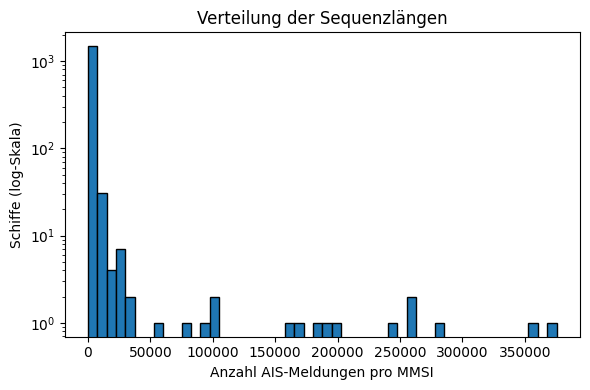

In [8]:
# ───────────────────────────────────────────────────────────────────────
# 8) Sequenzlängen pro Schiff untersuchen
# ───────────────────────────────────────────────────────────────────────
seq_lens = df_clean.groupby("MMSI").size().rename("count")
print("⚓ Sequenzlängen pro MMSI (Top 10):")
display(seq_lens.sort_values(ascending=False).head(10))

# Histogramm der Sequenzlängen
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(seq_lens, bins=50, log=True, edgecolor="black")
plt.xlabel("Anzahl AIS-Meldungen pro MMSI")
plt.ylabel("Schiffe (log-Skala)")
plt.title("Verteilung der Sequenzlängen")
plt.tight_layout()
plt.show()

In [9]:
# ───────────────────────────────────────────────────────────────────────
# 9) Schiffe mit zu kurzer Sequenz entfernen (<20 Meldungen)
# ───────────────────────────────────────────────────────────────────────
min_len = 100
valid_mmsi = seq_lens[seq_lens >= min_len].index
df_final   = df_clean[df_clean["MMSI"].isin(valid_mmsi)].copy()
print(f"✅ Nach Mindestlänge ≥{min_len}: {len(valid_mmsi):,} Schiffe verbleibend ({len(seq_lens)-len(valid_mmsi):,} entfernt)\n")


✅ Nach Mindestlänge ≥100: 1,527 Schiffe verbleibend (13 entfernt)



## 2. Sliding-Window-Sequenzen erzeugen

Wir übersetzen jede MMSI-Zeitreihe in eine Liste von Sequenzen der Form (L * Features)

In [10]:
# ───────────────────────────────────────────────────────────────────────
# 10) Datenform für Sequenzmodell vorbereiten (mit einfachem tqdm)
# ───────────────────────────────────────────────────────────────────────
import numpy as np
from tqdm import tqdm  # statt tqdm.notebook

L = 20  # Fensterlänge
features = cols  # die zuvor bereinigten Features
X, y = [], []

print("🔄 Erstelle Sequenzen (nicht-überlappend)…")
mmsi_groups = list(df_final.groupby("MMSI"))
for mmsi, group in tqdm(mmsi_groups, desc="Schiffe", unit="Schiff"):
    g = group.sort_values("# Timestamp").reset_index(drop=True)
    # Label: 1, wenn irgendwo in der Sequenz Cargo
    label = int((g["is_cargo"] == 1).any())
    # nicht-überlappende Fenster
    for start in range(0, len(g) - L + 1, L):
        seq = g.loc[start:start+L-1, features].values
        X.append(seq)
        y.append(label)

X = np.array(X)
y = np.array(y)
print(f"📐 Fertig: X-Shape={X.shape}, y-Shape={y.shape}")

🔄 Erstelle Sequenzen (nicht-überlappend)…


Schiffe:   6%|▌         | 94/1527 [00:02<00:55, 25.74Schiff/s]

: 

: 

## 3. Train/Test-Split & Feature-Scaling

Für RNN/TCN hilft es oft, die Features (z. B. SOG, COG, Draught) zu normalisieren.